In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

from autoencoder import Autoencoder_cnn
from stacked_mnist import StackedMNISTData, DataMode
from verification_net import VerificationNet

import warnings
warnings.filterwarnings('ignore', category=Warning)

In [2]:
gen = StackedMNISTData(mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=10)

In [18]:
#model = Autoencoder_cnn(n_channels=1, criterion=nn.BCELoss(),latent_dim=4) 

Epoch:1, Loss:0.1952
Epoch:2, Loss:0.1804
Epoch:3, Loss:0.1712
Epoch:4, Loss:0.1643
Epoch:5, Loss:0.1589
Epoch:6, Loss:0.1551
Epoch:7, Loss:0.1521
Epoch:8, Loss:0.1493
Epoch:9, Loss:0.1470
Epoch:10, Loss:0.1453
Epoch:11, Loss:0.1432
Epoch:12, Loss:0.1411
Epoch:13, Loss:0.1391
Epoch:14, Loss:0.1381
Epoch:15, Loss:0.1365
Epoch:16, Loss:0.1360
Epoch:17, Loss:0.1340
Epoch:18, Loss:0.1338
Epoch:19, Loss:0.1322
Epoch:20, Loss:0.1313
Epoch:21, Loss:0.1303
Epoch:22, Loss:0.1291
Epoch:23, Loss:0.1284
Epoch:24, Loss:0.1272
Epoch:25, Loss:0.1268
Epoch:26, Loss:0.1253
Epoch:27, Loss:0.1246
Epoch:28, Loss:0.1239
Epoch:29, Loss:0.1235
Epoch:30, Loss:0.1233
Epoch:31, Loss:0.1214
Epoch:32, Loss:0.1215
Epoch:33, Loss:0.1207
Epoch:34, Loss:0.1190
Epoch:35, Loss:0.1190
Epoch:36, Loss:0.1186
Epoch:37, Loss:0.1190
Epoch:38, Loss:0.1178
Epoch:39, Loss:0.1169
Epoch:40, Loss:0.1168


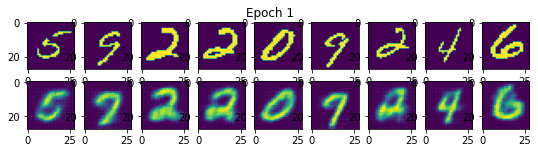

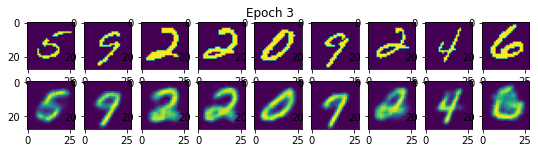

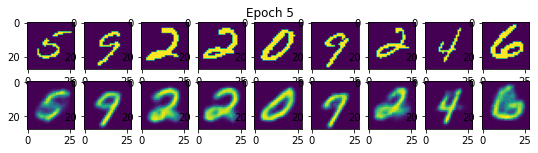

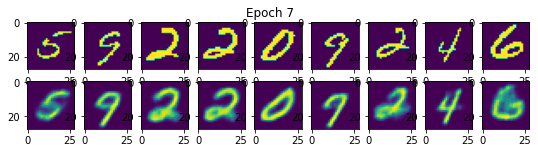

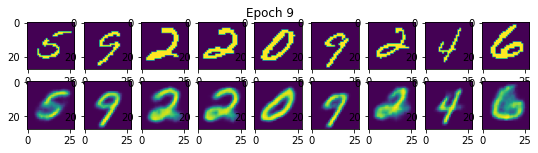

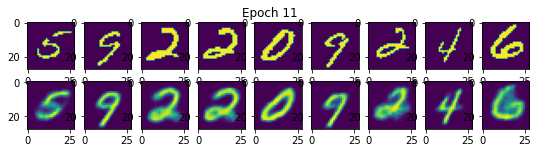

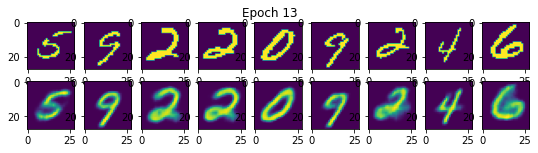

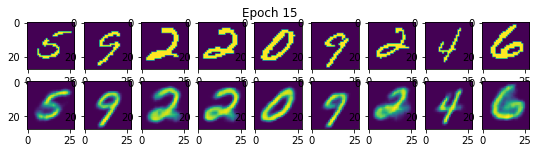

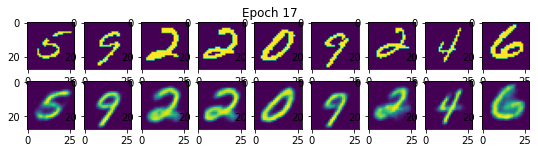

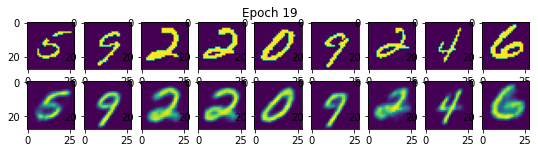

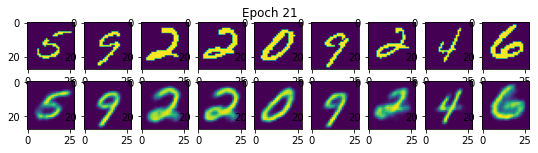

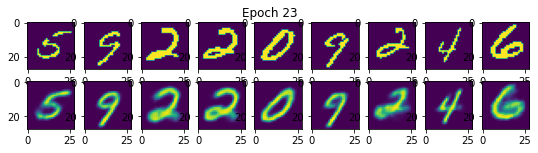

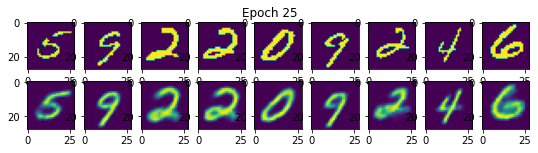

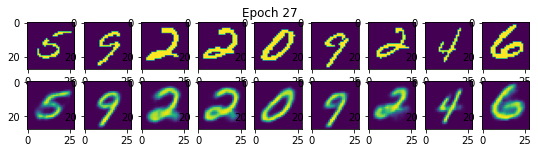

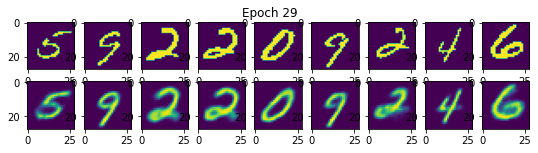

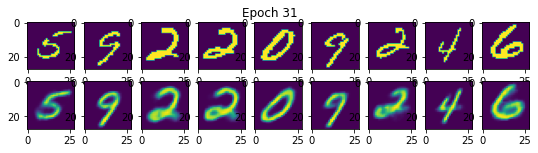

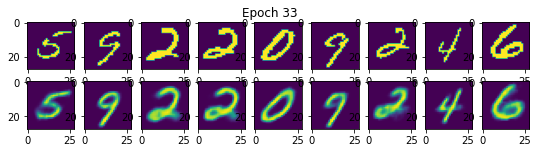

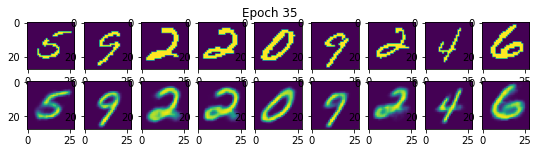

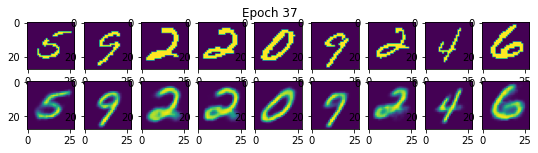

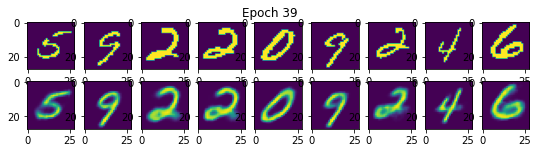

In [19]:
#model.fit(gen, epochs=40, visualize=True)

In [20]:
#model.save("autoencoders/model_1")

In [3]:
model = Autoencoder_cnn.load("autoencoders/model_1", n_channels=1, latent_dim=4)

## Test set

In [4]:
test_set = gen.get_full_data_set(training = False)
test_img, test_cls = test_set

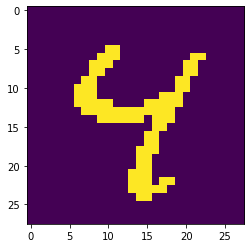

In [5]:
plt.imshow(test_img[6].astype(np.float32))

In [6]:
encoded = model.encode(test_img)

In [7]:
encoded.shape

torch.Size([10000, 4])

In [8]:
decoded = model.decode(encoded)

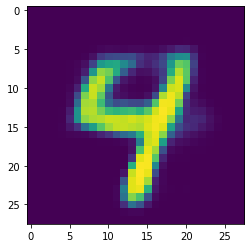

In [9]:
plt.imshow(decoded[6][0])

## Evaluation

In [10]:
net = VerificationNet("./models/verification_model")

In [11]:
decoded = decoded.squeeze(1)
decoded = np.expand_dims(decoded, axis=-1)

In [12]:
predictability, accuracy = net.check_predictability(data = decoded, correct_labels = test_cls)

313/313 [==============================] - 6s 17ms/step


In [13]:
print(f"Predictability is {predictability}. Accuracy is {accuracy}")

Predictability is 0.9613. Accuracy is 0.9054


# Autoencoder as generative model

In [14]:
generated_imgs = model.generate(10)

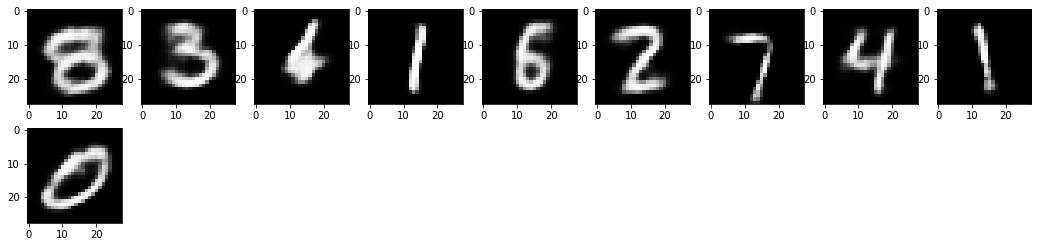

In [15]:
plt.figure(figsize=(18,4))
for i, item in enumerate(generated_imgs):
    plt.subplot(2,9,i+1)
    plt.imshow(np.transpose(item, (1, 2, 0)).astype(np.float), cmap="gray") 

In [16]:
generated_imgs = model.generate(1000)
generated_imgs = generated_imgs.squeeze(1)
generated_imgs = np.expand_dims(generated_imgs, axis=-1)
net.check_predictability(data = generated_imgs)
coverage = net.check_class_coverage(data=generated_imgs, tolerance=.8)
print(f"Predictability is {predictability}. Coverage is {coverage}")

32/32 [==============================] - 1s 15ms/step
Predictability is 0.9613. Coverage is 1.0


# Autoencoder as anomaly detector

In [17]:
gen_miss = StackedMNISTData(mode=DataMode.MONO_BINARY_MISSING, default_batch_size=10)

Epoch:1, Loss:0.2332
Epoch:2, Loss:0.2186
Epoch:3, Loss:0.2194
Epoch:4, Loss:0.1948
Epoch:5, Loss:0.1781
Epoch:6, Loss:0.1591
Epoch:7, Loss:0.1937
Epoch:8, Loss:0.1511
Epoch:9, Loss:0.1468
Epoch:10, Loss:0.1461
Epoch:11, Loss:0.1259
Epoch:12, Loss:0.1165
Epoch:13, Loss:0.1137
Epoch:14, Loss:0.1313
Epoch:15, Loss:0.1501
Epoch:16, Loss:0.1175
Epoch:17, Loss:0.1033
Epoch:18, Loss:0.0969
Epoch:19, Loss:0.1012
Epoch:20, Loss:0.1007


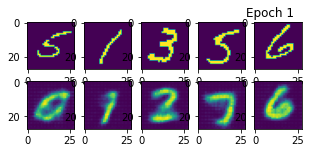

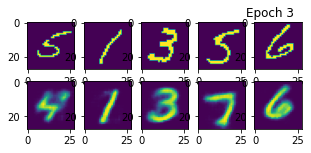

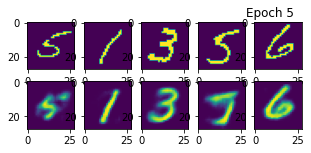

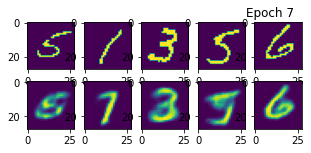

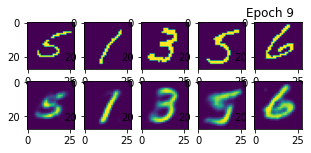

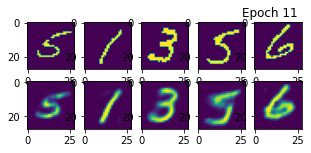

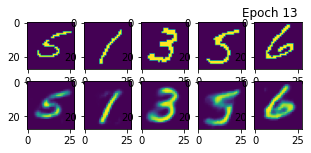

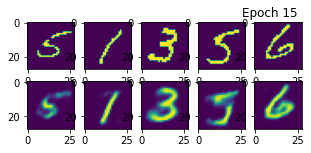

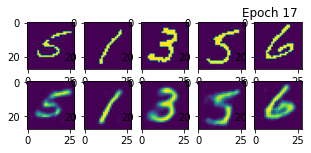

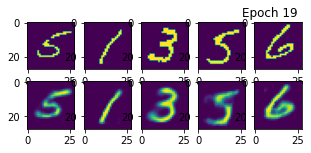

In [37]:
#model_miss = Autoencoder_cnn(n_channels=1, criterion=nn.BCELoss(),latent_dim=4)
#model_miss.fit(gen_miss, epochs=20, visualize=True)

In [38]:
#model_miss.save("autoencoders/model_miss")

In [18]:
model_miss = Autoencoder_cnn.load("autoencoders/model_miss", n_channels=1, latent_dim=4)

In [19]:
test_set = gen_miss.get_full_data_set(training = False)
test_img, test_cls = test_set

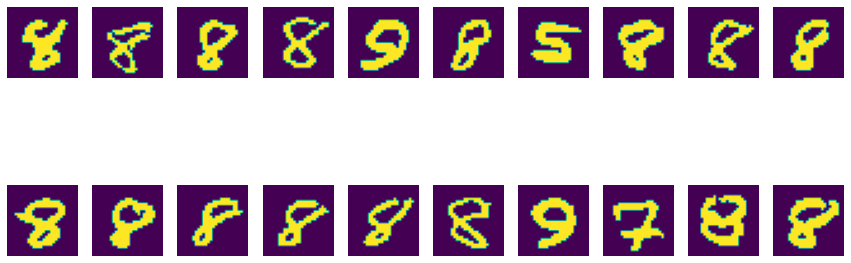

In [20]:
anomalies = model_miss.get_top_k_anomalious(test_img,20, show=True)

## Stacked 

In [21]:
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)

In [22]:
train_img, train_cls = gen.get_full_data_set(training = True)

In [23]:
train_img[0].shape

(28, 28, 3)

In [24]:
train_cls[2]

940

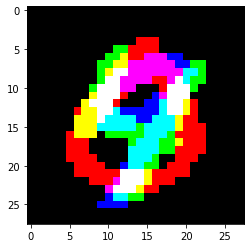

In [25]:
plt.imshow(train_img[2].astype(np.float))

In [26]:
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=32)

Epoch:1, Loss:0.2222
Epoch:2, Loss:0.2108
Epoch:3, Loss:0.1999
Epoch:4, Loss:0.1678
Epoch:5, Loss:0.1560
Epoch:6, Loss:0.1494
Epoch:7, Loss:0.1402
Epoch:8, Loss:0.1281
Epoch:9, Loss:0.1184
Epoch:10, Loss:0.1114
Epoch:11, Loss:0.1073
Epoch:12, Loss:0.1040
Epoch:13, Loss:0.1015
Epoch:14, Loss:0.0995
Epoch:15, Loss:0.0978
Epoch:16, Loss:0.0963
Epoch:17, Loss:0.0949
Epoch:18, Loss:0.0939
Epoch:19, Loss:0.0930
Epoch:20, Loss:0.0922
Epoch:21, Loss:0.0914
Epoch:22, Loss:0.0906
Epoch:23, Loss:0.0900
Epoch:24, Loss:0.0893
Epoch:25, Loss:0.0888
Epoch:26, Loss:0.0883
Epoch:27, Loss:0.0878
Epoch:28, Loss:0.0874
Epoch:29, Loss:0.0870
Epoch:30, Loss:0.0866
Epoch:31, Loss:0.0863
Epoch:32, Loss:0.0859
Epoch:33, Loss:0.0855
Epoch:34, Loss:0.0852
Epoch:35, Loss:0.0849
Epoch:36, Loss:0.0844
Epoch:37, Loss:0.0840
Epoch:38, Loss:0.0836
Epoch:39, Loss:0.0832
Epoch:40, Loss:0.0831


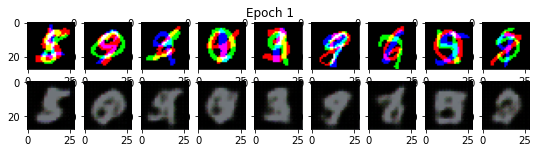

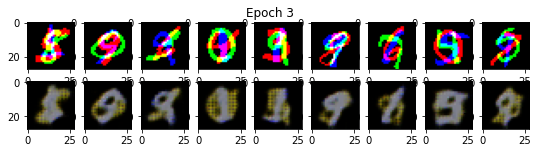

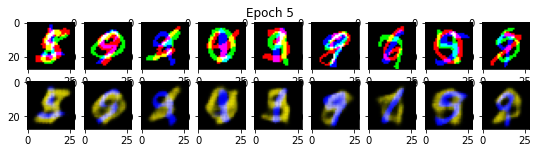

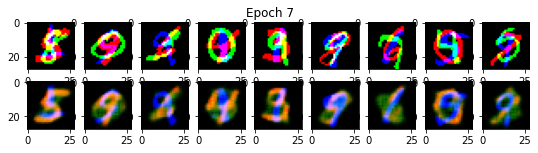

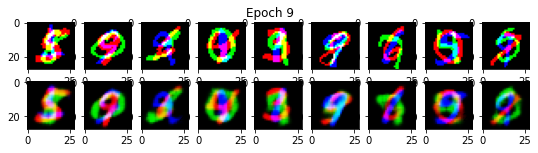

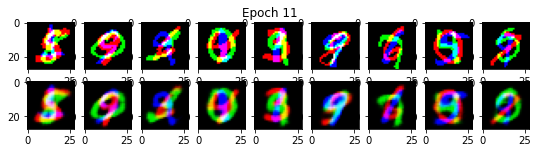

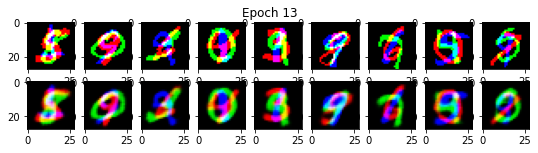

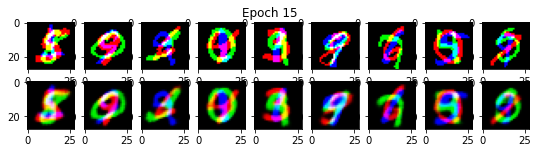

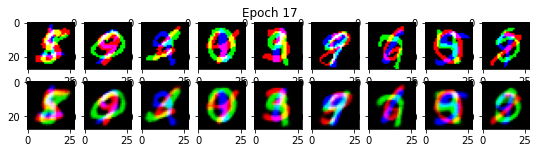

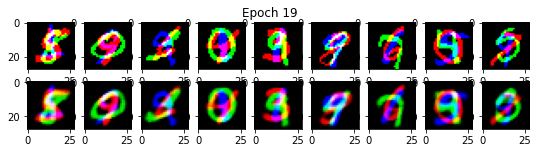

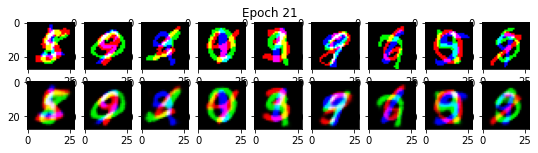

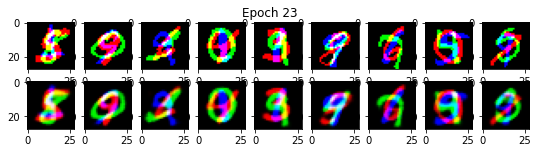

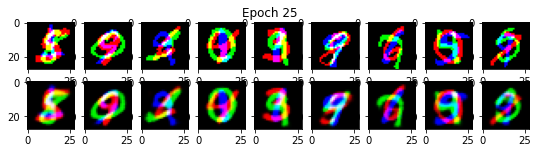

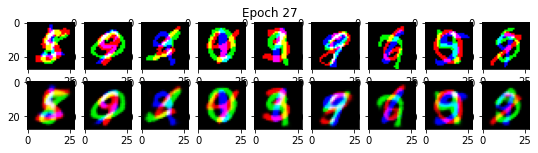

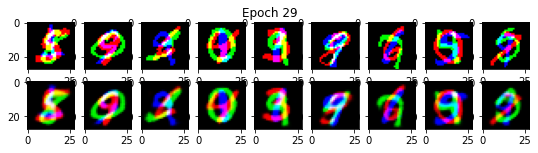

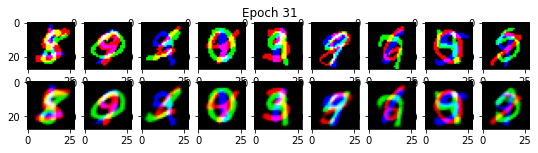

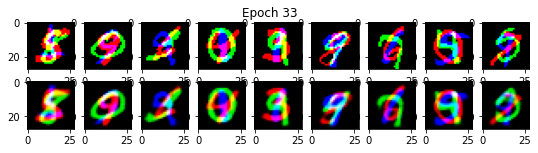

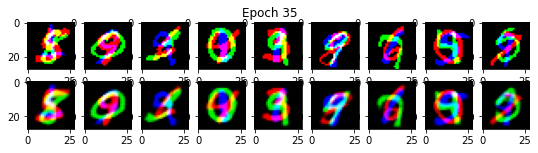

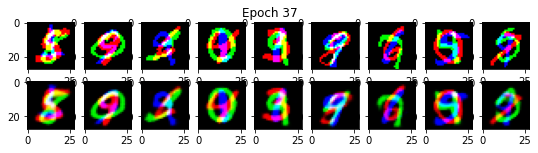

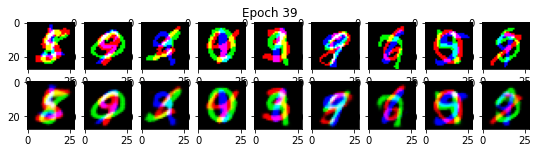

In [48]:
#model_rgb = Autoencoder_cnn(n_channels=3,criterion=nn.BCELoss(), latent_dim=64)
#gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=32)
#model_rgb.fit(gen, epochs=40, visualize=True)

In [49]:
#model_rgb.save("autoencoders/model_rgb")

In [27]:
model_rgb = Autoencoder_cnn.load("autoencoders/model_rgb", n_channels=3, latent_dim=64)

## Test set

In [28]:
test_set = gen.get_full_data_set(training = False)

In [29]:
test_img, test_cls = test_set

In [30]:
encoded = model_rgb.encode(test_img)

In [31]:
decoded = model_rgb.decode(encoded)

In [32]:
predictability, accuracy = net.check_predictability(data = decoded.transpose((0,2,3,1)), correct_labels = test_cls, tolerance=0.5)

313/313 [==============================] - 5s 17ms/step


In [33]:
print(f"Predictability is {predictability}. Accuracy is {accuracy}")

Predictability is 0.9513. Accuracy is 0.8367


# AE as generative model

In [34]:
encoded.shape

torch.Size([10000, 64])

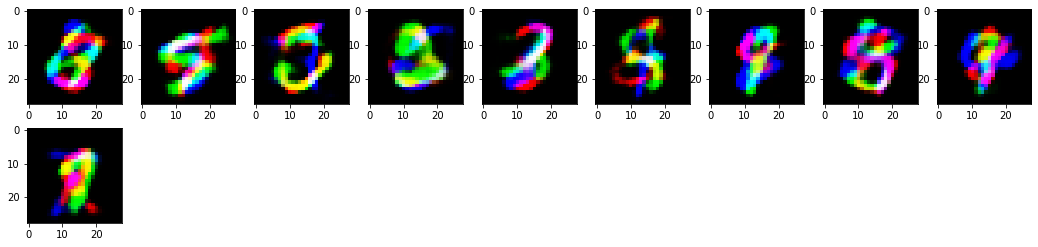

In [35]:
generated_imgs = model_rgb.generate(10)
plt.figure(figsize=(18,4))
for i, item in enumerate(generated_imgs):
    plt.subplot(2,9,i+1)
    plt.imshow(np.transpose(item, (1, 2, 0)).astype(np.float)) 

In [36]:
generated_imgs = model_rgb.generate(1000)
net.check_predictability(data = generated_imgs.transpose((0,2,3,1)))
coverage = net.check_class_coverage(data=generated_imgs.transpose((0,2,3,1)), tolerance=.5)
print(f"Predictability is {predictability}. Coverage is {coverage}")

32/32 [==============================] - 1s 16ms/step
Predictability is 0.9513. Coverage is 0.324


# Stacked AE as Anomaly Detector

In [37]:
gen_miss_stacked = StackedMNISTData(mode=DataMode.COLOR_BINARY_MISSING, default_batch_size=10)

Epoch:1, Loss:0.2384
Epoch:2, Loss:0.2271
Epoch:3, Loss:0.2200
Epoch:4, Loss:0.2140
Epoch:5, Loss:0.2096
Epoch:6, Loss:0.2040
Epoch:7, Loss:0.1862
Epoch:8, Loss:0.1657
Epoch:9, Loss:0.1614
Epoch:10, Loss:0.1520
Epoch:11, Loss:0.1381
Epoch:12, Loss:0.1384
Epoch:13, Loss:0.1232
Epoch:14, Loss:0.1158
Epoch:15, Loss:0.1102
Epoch:16, Loss:0.1077
Epoch:17, Loss:0.1053
Epoch:18, Loss:0.1025
Epoch:19, Loss:0.0995
Epoch:20, Loss:0.0964


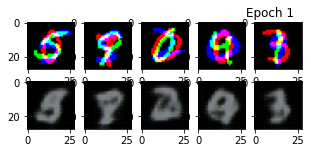

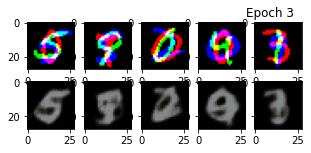

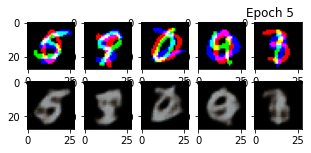

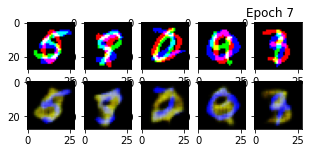

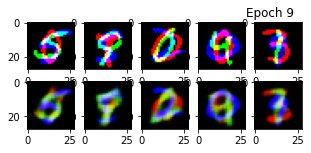

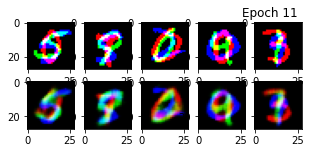

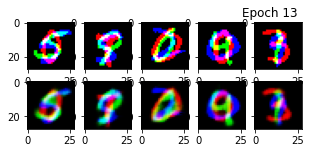

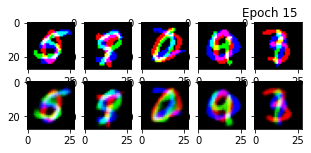

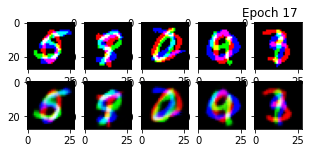

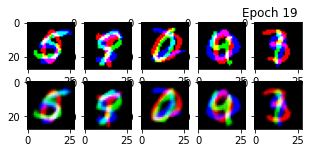

In [60]:
#model_miss_stacked = Autoencoder_cnn(n_channels=3, criterion=nn.BCELoss(),latent_dim=64)
#model_miss_stacked.fit(gen_miss_stacked, epochs=20, visualize=True)

In [61]:
#model_miss_stacked.save("autoencoders/model_miss_stacked")

In [38]:
model_miss_stacked = Autoencoder_cnn.load("autoencoders/model_miss_stacked", n_channels=3, latent_dim=64)

In [39]:
test_set = gen_miss_stacked.get_full_data_set(training = False)
test_img, test_cls = test_set

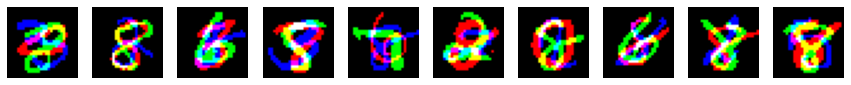

In [42]:
anomalies = model_miss_stacked.get_top_k_anomalious(test_img,10, show=True)

# VAE